In [1]:
import yahoo_fin.stock_info as si
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels as sm

In this notebook, we walk thought the examples on Algorithmic trading (P. Chan, 2013) Chapter 2: The Basics of Mean Reversion.
The results obtained are not exact but very close to the book's.

## Example 2.1
Linear price chagnes model: $Δy(t)=λy(t−1)+μ+βt+α_1Δy(t−1)+...+α_kΔy(t−k)+ t $


In [2]:
# Download data form yhaoo finance
start_date="2007-07-22"
end_date="2012-03-28"
CAD = si.get_data('CAD=X', start_date, end_date)['close']
CAD = CAD.fillna(method='ffill')

In [3]:
import statsmodels.tsa.stattools as ts
result = ts.adfuller(CAD,1,autolag=None)
print(f"ADF test statiestic: {result[0]:.4f}")
print(f"Confident level    : {1-result[1]:.4f}")

ADF test statiestic: -1.8388
Confident level    : 0.6386


We cannot reject the $H_0$ that CAD is non-stationary

## Example 2.2 : Hurst Exponent
$〈|z(t + τ) − z(t)|^2〉 ∼ τ^{2H} $,where $z=\ln(CAD)$

The time series is mean reverting if the Hurst Exponent $H<0.5$

In [4]:
def get_hurst_exponent(time_series, max_lag=100):
    """Returns the Hurst Exponent of the time series"""
    
    lags = range(2, max_lag)

    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]

    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)

    return reg[0]
hurst = get_hurst_exponent((CAD.values))
print(f"Hurst : {hurst:.4f}")

Hurst : 0.4658


It indicates that CAD is weakly mean-reverting

## Example 2.3: Variance Ratio Test

## Example 2.4: Half-life
$dy(t)=(\lambda y(t-1)+\mu)dt+d\epsilon$

We find $\lambda$ by regressing $\Delta CAD_t=\alpha +\lambda CAD_{t-1}$

and half-life = $\frac{\ln2}{\lambda }$

In [6]:
import statsmodels.api as sm

def halflife(x):
    x_lag = x.shift(1).dropna()
    delta_x = (x-x_lag).dropna()
    model = sm.OLS(delta_x, sm.add_constant(x_lag))
    result = model.fit()
    return -np.log(2)/list(result.params)[1]
halflife(CAD)

124.0402469565211

## Example 2.5 Mean-reverting strategy using half-life found

The portfolio will hold $-z=-\frac{CAD-E[CAD]}{sd(CAD)}$ amount of CAD

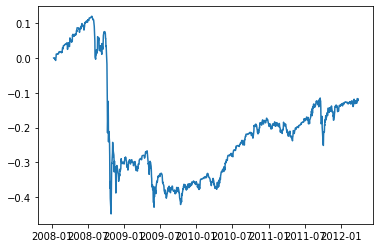

In [8]:
lookback = int(np.floor(halflife(CAD)))
mktValue = -(CAD-CAD.rolling(lookback).mean())/CAD.rolling(lookback).std()
pnl = mktValue.shift(1) * CAD.pct_change()
plt.plot((1+pnl).cumprod()-1)

## Example 2.6: CADF test for Cointegration

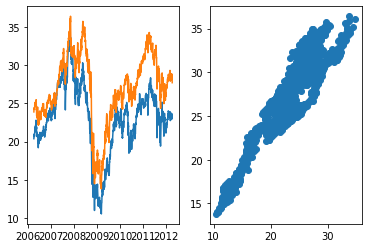

In [9]:
EWA = si.get_data('EWA',"2006-04-04","2012-04-09")['close']
EWC = si.get_data('EWC',"2006-04-04","2012-04-09")['close']
fig, axs = plt.subplots(1,2)
axs[0].plot(EWA)
axs[0].plot(EWC)
axs[1].scatter(EWA,EWC)

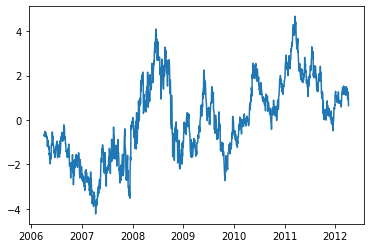

In [10]:
regress_result=sm.OLS(EWC,sm.add_constant(EWA)).fit()
regress_result.params[0]
plt.plot(EWC-regress_result.params[0]-regress_result.params[1]*EWA)

In [11]:
result = ts.coint(EWC, EWA, 'ct', maxlag=1)
result

(-3.646515463091755,
 0.07033367855292645,
 array([-4.33783962, -3.7868612 , -3.50099372]))

## Example 2.7: Johensen Test
$ΔY(t) = ΛY(t − 1) + M + A_1ΔY(t − 1) + ... + A_k ΔY(t − k) + \epsilon_t (2.7)$

In [12]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
def johansen(Y):
    result = coint_johansen(Y,0,1)
    print(f"trace_stat {result.lr1}")
    print(f"trace_stat_crit_vals {result.cvt}")
    print(f"eigen {result.lr2}")
    print(f"eigen_crit_vals {result.cvm}")
    return result

In [14]:
johansen(np.array([list(EWC),list(EWA)]).transpose())

trace_stat [13.45283907  4.12807554]
trace_stat_crit_vals [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
eigen [9.32476352 4.12807554]
eigen_crit_vals [[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


In [15]:
IGE = si.get_data("IGE","2006-04-04","2012-04-09")['close']
result = johansen(np.array([list(EWC),list(EWA),list(IGE)]).transpose())

trace_stat [28.24177066 14.03563181  4.57709076]
trace_stat_crit_vals [[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
eigen [14.20613886  9.45854105  4.57709076]
eigen_crit_vals [[18.8928 21.1314 25.865 ]
 [12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


31.393221982918092


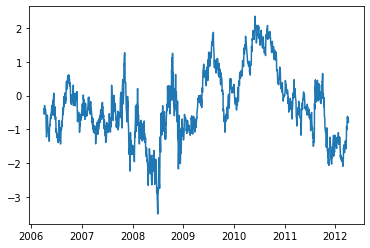

In [16]:
port = pd.concat({'EWC':EWC,"EWA":EWA,"IGE":IGE},axis=1)
weight = pd.Series(index = ['EWC',"EWA",'IGE'], data=result.evec[:,0])
yport = port.multiply(weight).sum(axis=1)
plt.plot(yport)
h = halflife(yport)
print(h)

## Example 8

In [17]:
ret = port.pct_change()
ret = ret.multiply(weight).sum(axis=1)
lookback = int(np.floor(h))
holdingUnit = -(yport-yport.rolling(lookback).mean())/yport.rolling(lookback).std()
portReturn = holdingUnit.shift()*ret

APR   : 0.0057
Sharpe: 0.0952


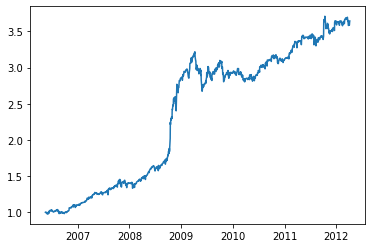

In [20]:
plt.plot((1+portReturn).cumprod())
print(f"APR   : {np.log((1+portReturn).prod())/225:.4f}")
print(f"Sharpe: {np.mean(portReturn)/np.std(portReturn):.4f}")